../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator()

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import src.config
import src.data
import src.model_new
import src.utils
from src.model_new import (
    T5EncoderModelForSequenceClassification,
)

import gc
import copy
import random

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.utils

from transformers import (
    T5Tokenizer,
    DataCollatorForTokenClassification,
    T5ForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

import peft
from peft import (
    LoraConfig,
)

In [3]:
ROOT = src.utils.get_project_root_path()
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

EXPERT = 'ALL'
MODEL_VERRSION = src.config.model_version

adapter_location = f'/models/moe_v{MODEL_VERRSION}_gate'

SEED = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print("Base Model:\t", src.config.base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
print("Path:\t\t", ROOT)
print(f"Using device:\t {device}")

Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 False
Path:		 /home/ec2-user/developer/prottrans-t5-signalpeptide-prediction
Using device:	 cuda:0


In [4]:
t5_tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    do_lower_case=False,
    use_fast=True,
    legacy=False
)

In [5]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set.fasta'
# FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
annotations_name = 'Type' # Choose Type or Label

df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))

dataset_signalp = src.model_new.create_datasets(
        splits=src.config.splits,
        tokenizer=t5_tokenizer,
        data=df_data,
        annotations_name=annotations_name,
        dataset_size=src.config.dataset_size,
        sequence_type=EXPERT
        )

del df_data

In [6]:
dataset_signalp = dataset_signalp.rename_column("type", "labels")

In [7]:
print(EXPERT)
# print(dataset_signalp_type_splits)
print(dataset_signalp)

ALL
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12462
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4149
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4147
    })
})


In [8]:
# pd.Series(dataset_signalp['train']['labels']).value_counts()

In [9]:
t5_base_model = T5EncoderModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    device_map='auto',
    load_in_8bit=False,
    custom_num_labels=len(src.config.type_encoding),
    custom_dropout_rate=0.1,
)

tmp_lin_in = nn.Linear(
    in_features=t5_base_model.config.hidden_size,
    out_features=t5_base_model.config.hidden_size
)
tmp_lin_out = nn.Linear(
    in_features=t5_base_model.config.hidden_size,
    out_features=t5_base_model.custom_num_labels
)

t5_base_model.custom_classifier_in.weight = tmp_lin_in.weight
t5_base_model.custom_classifier_in.bias = tmp_lin_in.bias
t5_base_model.custom_classifier_out.weight = tmp_lin_out.weight
t5_base_model.custom_classifier_out.bias = tmp_lin_out.bias

modules_to_save = ['custom_classifier_in', 'custom_classifier_out']

lora_config = LoraConfig(
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=['q', 'k', 'v', 'o'],
    bias="none",
    modules_to_save=modules_to_save,
)

t5_lora_model = peft.get_peft_model(t5_base_model, lora_config)
t5_lora_model.print_trainable_parameters()

Some weights of T5EncoderModelForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50 and are newly initialized: ['custom_classifier_out.weight', 'custom_classifier_out.bias', 'custom_classifier_in.weight', 'custom_classifier_in.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 6,039,560 || all params: 1,214,181,384 || trainable%: 0.49741826712111736


In [10]:
# data_collator = DataCollatorForTokenClassification(tokenizer=t5_tokenizer)

training_args = TrainingArguments(
    output_dir='./checkpoints',
    learning_rate=src.config.lr,
    per_device_train_batch_size=src.config.batch_size,
    per_device_eval_batch_size=src.config.batch_size,
    num_train_epochs=src.config.num_epochs,
    logging_steps=src.config.logging_steps,
    evaluation_strategy="steps",
    eval_steps=src.config.eval_steps,
    save_strategy="steps",
    save_steps=src.config.save_steps,
    # gradient_accumulation_steps=accum,
    # load_best_model_at_end=True,
    # save_total_limit=5,
    seed=42,
    # fp16=True,
    # deepspeed=deepspeed_config,
    remove_unused_columns=False,
    label_names=['labels'],
    # debug="underflow_overflow",
)

trainer = Trainer(
    model=t5_lora_model,
    args=training_args,
    train_dataset=dataset_signalp['train'],
    eval_dataset=dataset_signalp['valid'],
    # data_collator=data_collator,
    compute_metrics=src.model_new.compute_metrics,
)

In [11]:
initial_validation=trainer.evaluate()
added_initial_validation = False
print(initial_validation)

{'eval_loss': 1.3807939291000366, 'eval_accuracy_metric': 0.32537960954446854, 'eval_precision_metric': 0.32537960954446854, 'eval_recall_metric': 0.32537960954446854, 'eval_f1_metric': 0.32537960954446854, 'eval_matthews_correlation': 0.0, 'eval_confusion_matrix': array([[1005,  605,  152, 1313],
       [ 205,  304,   55,  115],
       [ 145,   69,   32,   59],
       [  24,   55,    2,    9]]), 'eval_runtime': 244.6173, 'eval_samples_per_second': 16.961, 'eval_steps_per_second': 1.063}


In [12]:
gc.collect()
torch.cuda.empty_cache()
# torch.mps.empty_cache()

trainer.train()

Step,Training Loss,Validation Loss,Accuracy Metric,Precision Metric,Recall Metric,F1 Metric,Matthews Correlation,Confusion Matrix
300,0.022400,0.076477,0.985780,0.985780,0.985780,0.985780,0.000000,[[3061 12 2 0] [ 16 655 7 1] [ 3 9 293 0] [ 1 3 5 81]]
600,0.006200,0.064395,0.986503,0.986503,0.986503,0.986503,0.000000,[[3060 13 2 0] [ 16 656 6 1] [ 3 12 290 0] [ 1 2 0 87]]


TrainOutput(global_step=779, training_loss=0.15529780261608891, metrics={'train_runtime': 1630.5694, 'train_samples_per_second': 7.643, 'train_steps_per_second': 0.478, 'total_flos': 6445159428725856.0, 'train_loss': 0.15529780261608891, 'epoch': 1.0})

In [13]:
final_validation=trainer.evaluate()
print(final_validation)

{'eval_loss': 0.06294456869363785, 'eval_accuracy_metric': 0.9865027717522294, 'eval_precision_metric': 0.9865027717522294, 'eval_recall_metric': 0.9865027717522294, 'eval_f1_metric': 0.9865027717522294, 'eval_matthews_correlation': 0.0, 'eval_confusion_matrix': array([[3060,   13,    2,    0],
       [  15,  656,    7,    1],
       [   3,   12,  290,    0],
       [   1,    2,    0,   87]]), 'eval_runtime': 245.9264, 'eval_samples_per_second': 16.871, 'eval_steps_per_second': 1.057, 'epoch': 1.0}


In [14]:
if 'training_log' not in locals():
    training_log = pd.DataFrame(trainer.state.log_history)
else:
    training_log = pd.concat([training_log, pd.DataFrame(trainer.state.log_history)], ignore_index=True)
if not added_initial_validation:
    added_initial_validation = True
    training_log = pd.concat([pd.DataFrame([initial_validation]), training_log], ignore_index=True)
display(training_log)

,eval_loss,eval_accuracy_metric,eval_precision_metric,eval_recall_metric,eval_f1_metric,eval_matthews_correlation,eval_confusion_matrix,eval_runtime,eval_samples_per_second,eval_steps_per_second,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.380794,0.325380,0.325380,0.325380,0.325380,0.0,"[[1005, 605, 152, 1313], [205, 304, 55, 115], ...",244.6173,16.961,1.063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3855,9.987163e-05,0.00,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3632,9.974326e-05,0.00,2.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3435,9.961489e-05,0.00,3.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3451,9.948652e-05,0.01,4.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0100,2.567394e-07,1.00,777.0,NaN,NaN,NaN,NaN,NaN
780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0441,1.283697e-07,1.00,778.0,NaN,NaN,NaN,NaN,NaN
781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0428,0.000000e+00,1.00,779.0,NaN,NaN,NaN,NaN,NaN
782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,779.0,1630.5694,7.643,0.478,6.445159e+15,0.155298


In [15]:
if 'eval_confusion_matrix' in training_log.columns:
    training_log['eval_confusion_matrix'] = training_log['eval_confusion_matrix'].apply(lambda x: x.tolist() if type(x)==np.ndarray else None)
t5_lora_model.save_pretrained(ROOT + adapter_location)
training_log.to_csv(ROOT + adapter_location + '/training_log.csv', index=False)
training_log.to_parquet(ROOT + adapter_location + '/training_log.parquet')

In [16]:
training_log = pd.read_parquet(ROOT + adapter_location + '/training_log.parquet')

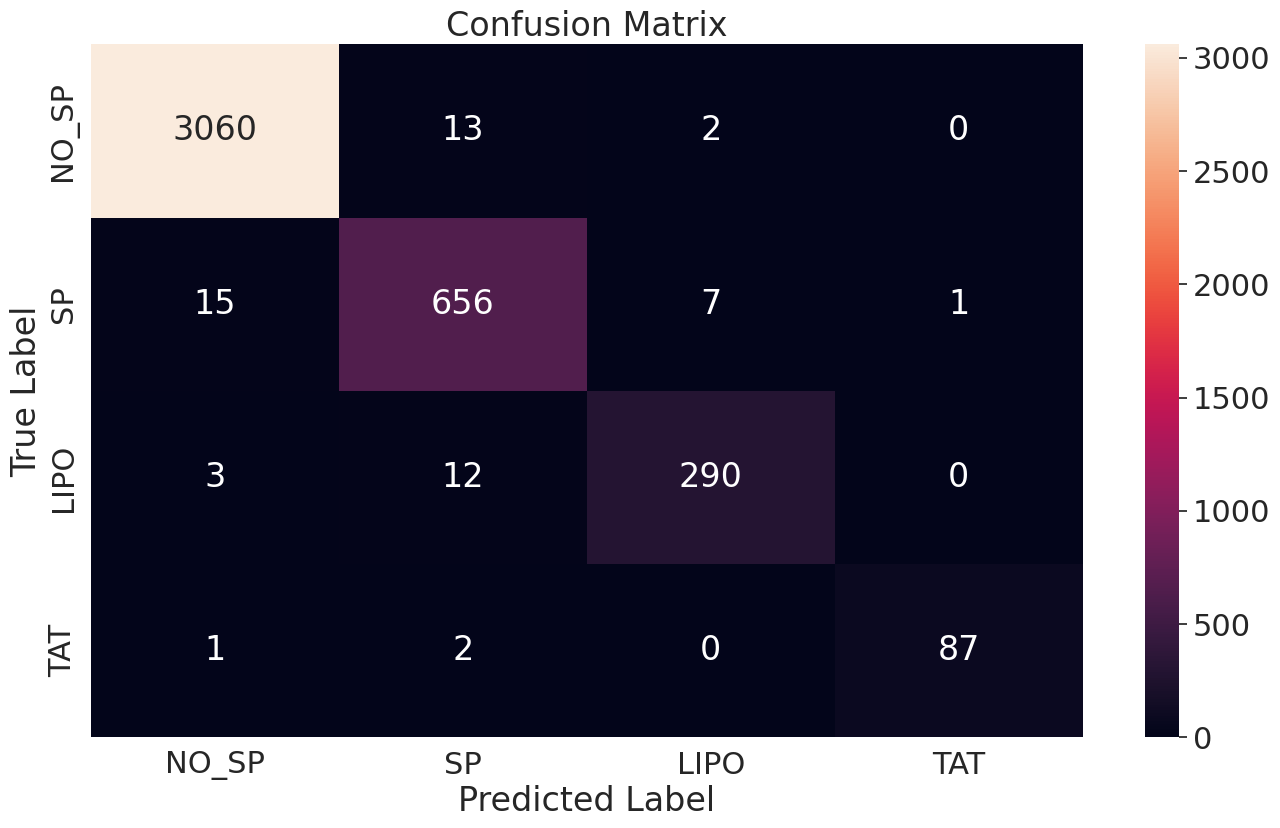

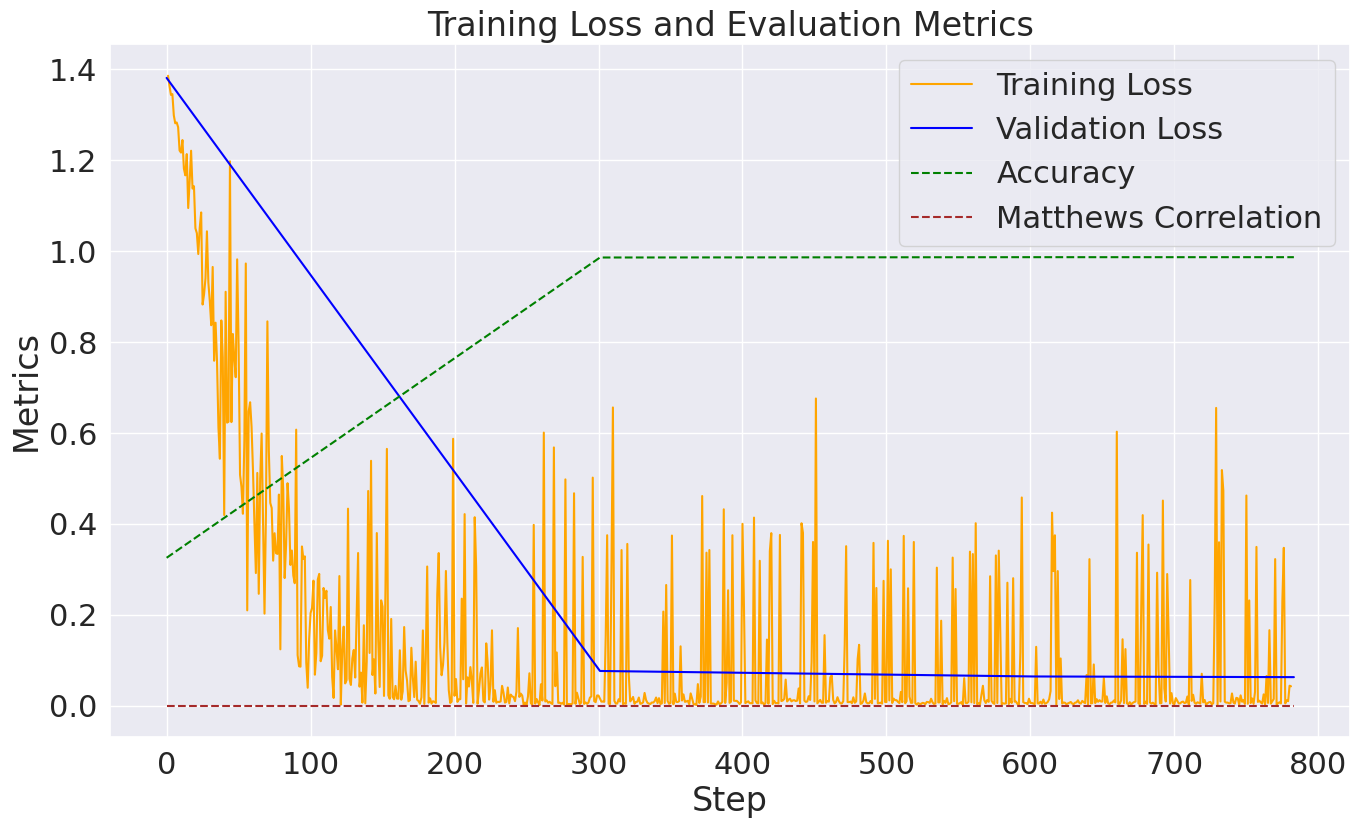

In [20]:
src.model_new.confusion_matrix_plot(
    np.array(training_log['eval_confusion_matrix'][training_log['eval_confusion_matrix'].notnull()].iloc[-1].tolist()),
    src.config.type_decoding
    )
plt.savefig(ROOT + adapter_location + '/fig_cm.jpg', dpi=400)

src.model_new.loss_plot(training_log)
plt.savefig(ROOT + adapter_location + '/fig_loss.jpg', dpi=400)

In [ ]:
# _ds_index = 2
# _ds_type = 'test'

# _input_ids_test = t5_tokenizer.decode(dataset_signalp[_ds_type][_ds_index]['input_ids'][:-1])
# _labels_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['labels']]).to(device)
# _attention_mask_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['attention_mask']]).to(device)

# _labels_test_decoded = [src.config.type_decoding[x] for x in _labels_test.tolist()]

# print('Iput IDs:\t', _input_ids_test)
# print('Labels:\t\t', _labels_test.tolist()[0])
# print('Labels Decoded:\t', *_labels_test_decoded)
# print('Attention Mask:\t', *_attention_mask_test.tolist()[0])
# print('----')

# preds = src.model_new.predict_model(
#     sequence=_input_ids_test,
#     tokenizer=t5_tokenizer,
#     model=t5_lora_model,
#     labels=_labels_test,
#     attention_mask=_attention_mask_test,
#     device=device,
#     )

# _result = src.model_new.translate_logits(
#     logits=preds.logits.unsqueeze(0),
#     decoding=src.config.type_decoding
#     )

# print('logits\t\t', preds.logits)
# print('Result: \t',* _result)

In [ ]:
torch.round(preds.logits.softmax(-1), decimals=3)